In [1]:
import os
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import scvi
import scanpy as sc
import squidpy as sq
import tangram as tg
import cellcharter as cc
import matplotlib.pyplot as plt
import matplotlib.colors as col

Global seed set to 0


In [2]:
#Set working directory
os.chdir("../")

# Load data

In [3]:
adata_list = []

for sample in ['WT', 'PRO', 'MES']:
    adata = sc.read_10x_h5(filename=f'XeniumData/Organoid_{sample}/cell_feature_matrix.h5')
    df = pd.read_csv(f'XeniumData/Organoid_{sample}/cells.csv.gz', compression='gzip')
    
    df.set_index(adata.obs_names, inplace=True)
    adata.obs = df.copy()

    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

    # subset to keep cells from seurat
    barcode = pd.read_csv(f"GBMOrganoid/Barcodes_{sample}.csv")
    adata = adata[df['cell_id'].isin(barcode['x'])]
    
    # add metadata from seurat analysis
    celltype = pd.read_csv(f"GBMOrganoid/PredCellType_{sample}.csv",sep=",",index_col=0)
    adata.obs["PredCellType"] = celltype['x'].astype('category')

    adata.obs['sample'] = sample
    adata.write_h5ad(f'GBMOrganoid/Checkpoints/xenium_{sample}organoid.h5ad')
    adata_list.append(adata)

In [4]:
adata = ad.concat(adata_list, axis=0, merge='same', pairwise=True, index_unique='_')

adata.obs['sample'] = pd.Categorical(adata.obs['sample'])
adata.obs['condition'] = adata.obs['sample'].astype('category')

## Normalize Data

In [5]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

## Visualize QC metrics

Negative DNA probe count % : 0.0010725081643676016
Negative decoding count % : 0.0010241243374036497


<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

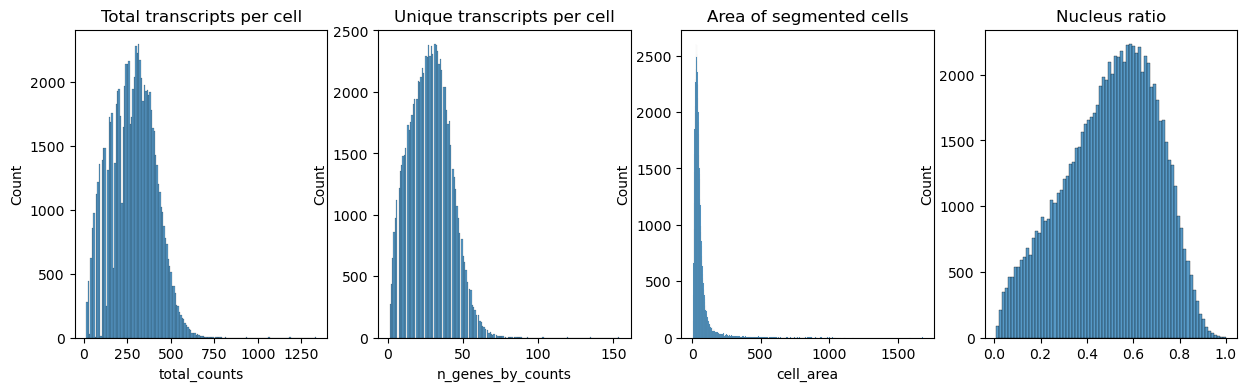

In [6]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

cprobes = (adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100)
cwords = (adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100)

print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(adata.obs["total_counts"],kde=False,ax=axs[0],)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(adata.obs["n_genes_by_counts"],kde=False,ax=axs[1],)

axs[2].set_title("Area of segmented cells")
sns.histplot(adata.obs["cell_area"],kde=False,ax=axs[2],)

axs[3].set_title("Nucleus ratio")
sns.histplot(adata.obs["nucleus_area"] / adata.obs["cell_area"],kde=False,ax=axs[3],)

In [7]:
# Save
adata.write_h5ad('GBMOrganoid/Checkpoints/xenium_organoids_raw.h5ad')

# CellCharter spatial clustering

## Demonsionality Reduction

In [8]:
scvi.settings.seed = 1234
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key='sample')

model = scvi.model.SCVI(adata)

Global seed set to 1234


In [9]:
model.train(early_stopping=True, enable_progress_bar=True)
model.save("GBMOrganoid/Checkpoints/scvi_model/organoids", overwrite=True)

Epoch 91/91: 100%|██████████| 91/91 [07:17<00:00,  4.81s/it, loss=78.5, v_num=1]


In [10]:
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)

## Spatial Clustering

In [11]:
sq.gr.spatial_neighbors(adata, library_key='sample', coord_type="generic", delaunay=True)
cc.gr.remove_long_links(adata)

In [12]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample')

  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
#autok = cc.tl.ClusterAutoK.load("GBMOrganoid/Checkpoints/ClusterAutoK/organoids")

autok = cc.tl.ClusterAutoK(n_clusters=(2,20), max_runs=10, model_params=dict(random_state=1234, trainer_params=dict(accelerator='gpu', devices=1)))
autok.fit(adata, use_rep='X_cellcharter')
autok.save("GBMOrganoid/Checkpoints/ClusterAutoK/organoids")

Iteration 1/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/21 [00:00<?, ?it/s]

Convergence with a change in stability of 0.007899548570606332 reached after 10 iterations


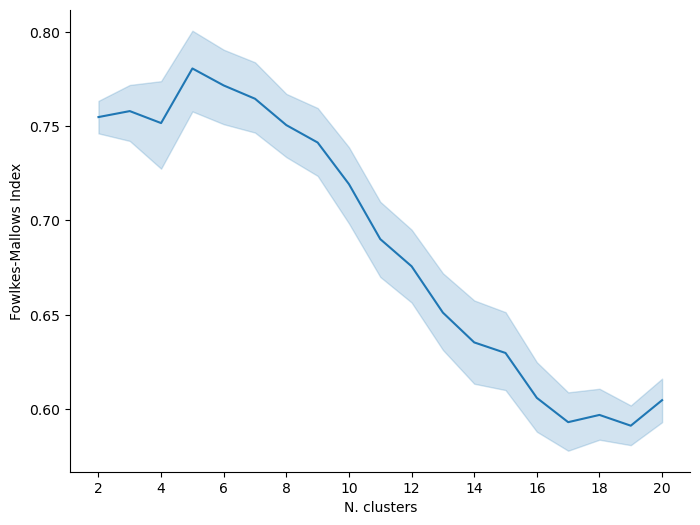

In [14]:
plt.figure(figsize=(8,6))
cc.pl.autok_stability(autok)
plt.xticks(np.arange(autok.n_clusters[1], autok.n_clusters[-1], 2))
plt.ylabel('Fowlkes-Mallows Index')
plt.show()

In [15]:
adata.obs['cluster_cellcharter'] = autok.predict(adata, use_rep='X_cellcharter')

In [16]:
adata.write_h5ad('GBMOrganoid/Checkpoints/xenium_organoids.h5ad')

# Analyze new data

In [17]:
adata = sc.read_h5ad('GBMOrganoid/Checkpoints/xenium_organoids.h5ad')
adata.uns['spatial'] = {s: {} for s in adata.obs['sample'].unique()}
adata

AnnData object with n_obs × n_vars = 87518 × 266
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'PredCellType', 'sample', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', '_scvi_batch', '_scvi_labels', 'cluster_cellcharter'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'spatial_neighbors', 'spatial'
    obsm: 'X_cellcharter', 'X_scVI', 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

## Visualize on Spatial Coordinates

In [18]:
colpal_clusters = ['#E69F00','#56B4E9','#009E73','#0072B2','#D55E00']
my_colors2 = col.ListedColormap(sns.color_palette(colpal_clusters))

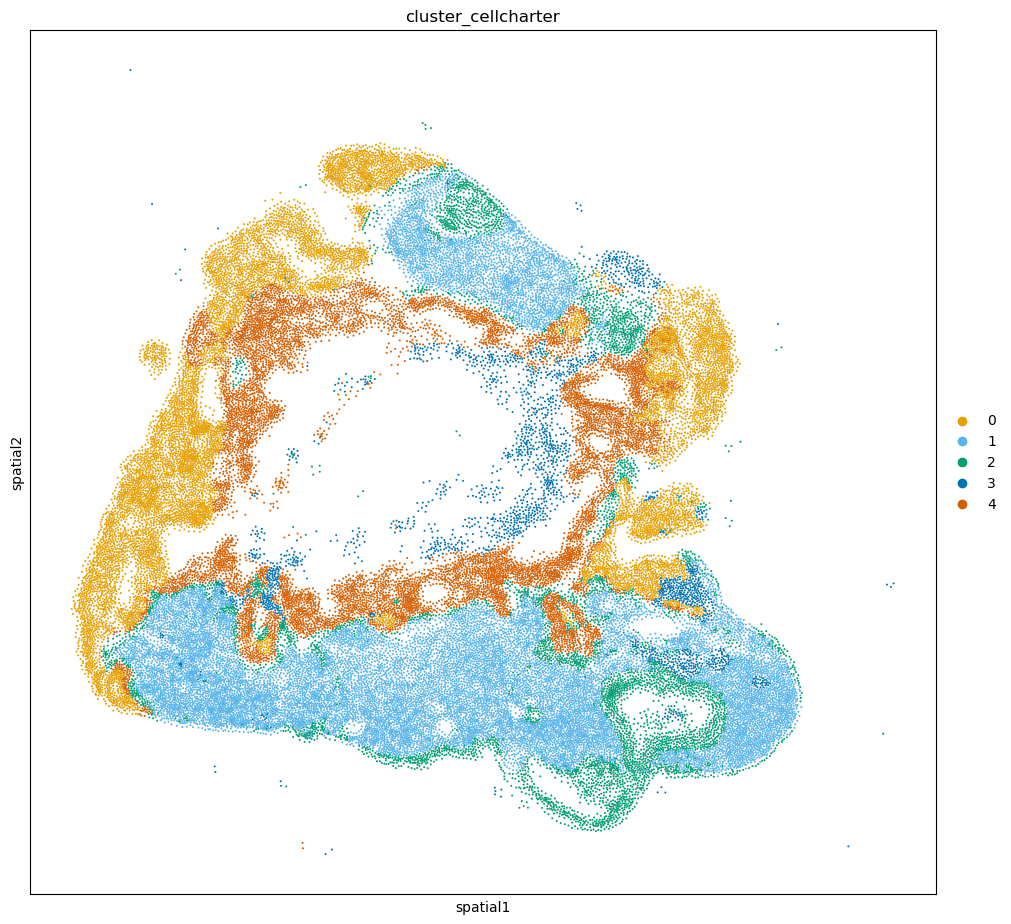

In [19]:
sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter'], 
    library_key='sample',  
    size=3, 
    img=None,
    spatial_key='spatial',
    palette=my_colors2,
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(10,10),
    ncols=1,
    #library_id=adata.obs['sample'].unique(),
    library_id=['WT'],
    frameon=True,title=None,
    save="GBMOrganoid/Figures/WTorganoid_clusters.jpg"
)

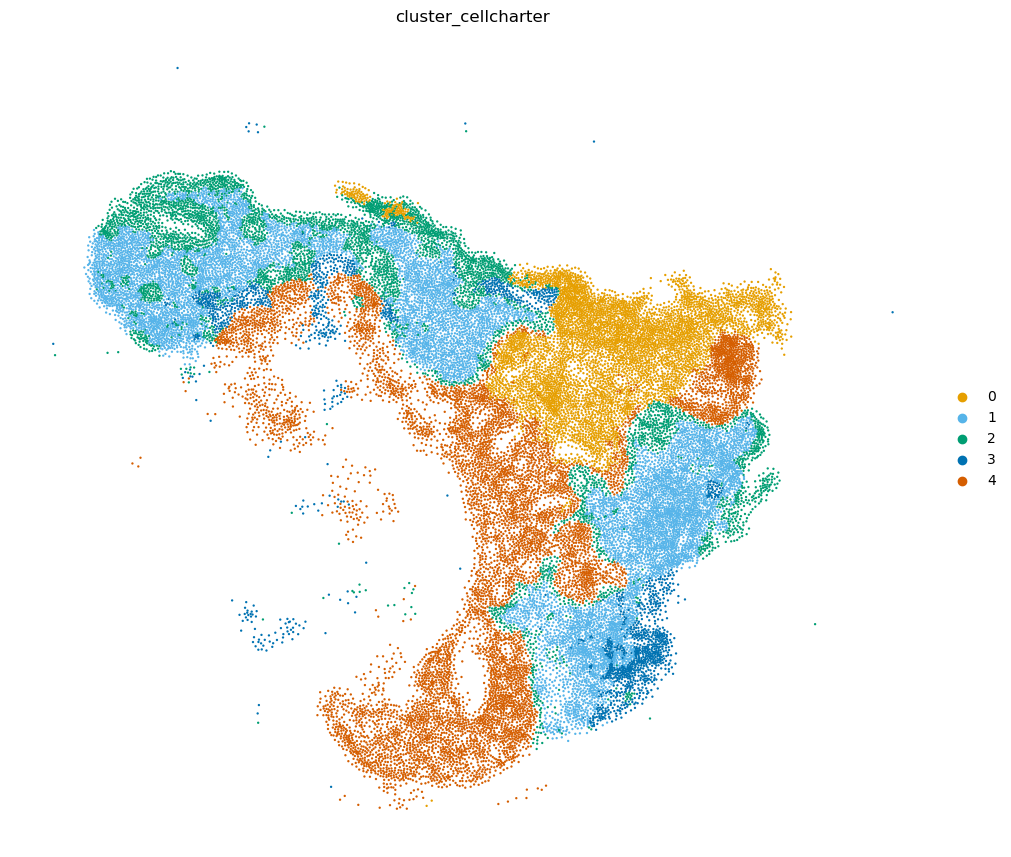

In [20]:
sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter'], 
    library_key='sample',  
    size=3, 
    img=None,
    spatial_key='spatial',
    palette=my_colors2,
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(10,10),
    ncols=1,
    #library_id=adata.obs['sample'].unique(),
    library_id=['PRO'],
    frameon=False,title=None,
    save="GBMOrganoid/Figures/PROorganoid_clusters.jpg"
)

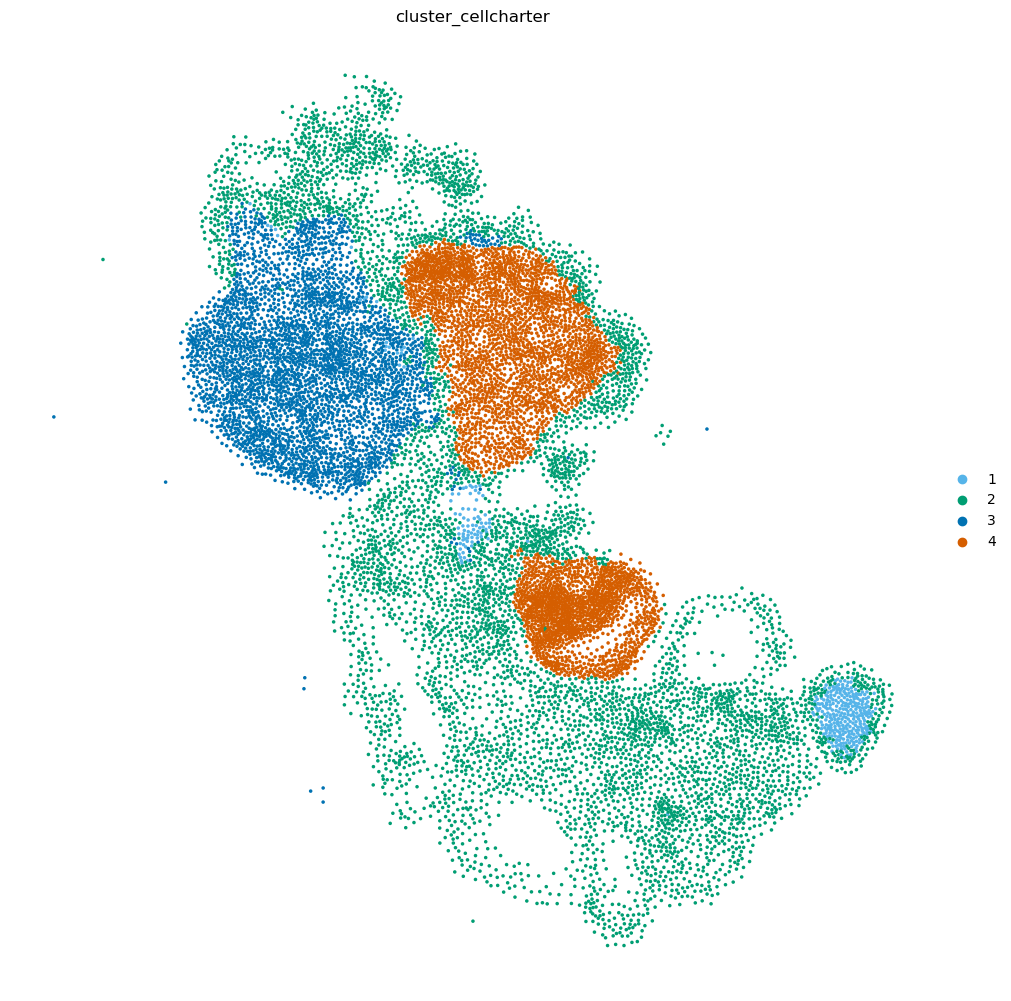

In [21]:
colpal = ['#56B4E9','#009E73','#0072B2','#D55E00']
col = col.ListedColormap(sns.color_palette(colpal))

sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter'], 
    library_key='sample',  
    size=3, 
    img=None,
    spatial_key='spatial',
    palette=col,
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(10,10),
    ncols=1,
    #library_id=adata.obs['sample'].unique(),
    library_id=['MES'],
    frameon=False,title=None,
    save="GBMOrganoid/Figures/MESorganoid_clusters.jpg"
)

In [22]:
colpal_cells = ['#BEBEBE','#8968CD','#90EE90','#20B2AA','#F08080','#000080','#696969','#7EC0EE','#FFC125']
my_colors = col.ListedColormap(sns.color_palette(colpal_cells))

AttributeError: 'ListedColormap' object has no attribute 'ListedColormap'

In [ ]:
sq.pl.spatial_scatter(
    adata, 
    color=['PredCellType'], 
    library_key='sample',  
    size=5, 
    img=None,
    spatial_key='spatial',
    palette=my_colors,
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(10,10),
    ncols=1,
    #library_id=adata.obs['sample'].unique(),
    library_id=['WT'],
    frameon=False,title=None,
    save="GBMOrganoid/Figures/WTorganoid_predcelltype.jpg"
)

In [ ]:
sq.pl.spatial_scatter(
    adata, 
    color=['PredCellType'], 
    library_key='sample',  
    size=5, 
    img=None,
    spatial_key='spatial',
    palette=my_colors,
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(10,10),
    ncols=1,
    #library_id=adata.obs['sample'].unique(),
    library_id=['PRO'],
    frameon=False,title=None,
    save="GBMOrganoid/Figures/PROorganoid_predcelltype.jpg"
)

In [ ]:
sq.pl.spatial_scatter(
    adata, 
    color=['PredCellType'], 
    library_key='sample',  
    size=5, 
    img=None,
    spatial_key='spatial',
    palette=my_colors,
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(10,10),
    ncols=1,
    #library_id=adata.obs['sample'].unique(),
    library_id=['MES'],
    frameon=False,title=None,
    save="GBMOrganoid/Figures/MESorganoid_predcelltype.jpg"
)

## Proximity Analysis

In [ ]:
cc.gr.enrichment(adata, group_key='PredCellType', label_key='cluster_cellcharter')

plt.figure(figsize=(6,6))
cc.pl.enrichment(adata, group_key='PredCellType', label_key='cluster_cellcharter', cluster_labels=False, color_threshold=1, size_threshold=1)

In [ ]:
colpal_cells = ['#BEBEBE','#8968CD','#90EE90','#20B2AA','#F08080','#000080','#696969','#7EC0EE','#FFC125']
my_colors = col.ListedColormap(sns.color_palette(colpal_cells))

In [ ]:
cross_tab = pd.crosstab(adata.obs['sample'],adata.obs['PredCellType'], normalize='index')*100
ax = cross_tab.plot(kind='bar', stacked=True, figsize=(8, 6), cmap=my_colors, width=0.9)
ax.get_legend().remove()
# Add labels to the bars
for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
# Set labels and title
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.rcParams['figure.figsize'] = [10, 10]

In [ ]:
cross_tab.to_csv("GBMOrganoid/Metrics/ClusterProps.csv")

## Shape characterization

In [ ]:
cc.gr.connected_components(adata, cluster_key='cluster_cellcharter')
cc.tl.boundaries(adata, min_hole_area_ratio=0.1)

In [ ]:
cc.tl.linearity(adata)
cc.tl.curl(adata)
cc.tl.elongation(adata)
cc.tl.purity(adata)

In [ ]:
cc.pl.shape_metrics(
    adata, 
    condition_key='condition', 
    condition_groups=['WT', 'MES'],
    cluster_key='cluster_cellcharter',
    metrics=('linearity', 'curl', 'elongation', 'purity'),
    cluster_id=[4,3,2,1], 
    title='shape metrics'
)

In [ ]:
cc.pl.shape_metrics(
    adata, 
    condition_key='condition', 
    condition_groups=['WT', 'PRO'],
    cluster_key='cluster_cellcharter',
    metrics=('linearity', 'curl', 'elongation', 'purity'),
    cluster_id=[4], 
    title='shape metrics'
)

## Neighborhood Enrichment - Cell Type

In [ ]:
key_cell = 'PredCellType'

In [ ]:
adata_wt = adata[adata.obs['condition'] == 'WT']

cc.gr.nhood_enrichment(
    adata_wt,
    cluster_key= key_cell,
)

cc.pl.nhood_enrichment(
    adata_wt,
    cluster_key= key_cell,
    annotate=True,
    vmin=-0.5,
    vmax=0.5
)

In [ ]:
adata_pro = adata[adata.obs['condition'] == 'PRO']

cc.gr.nhood_enrichment(
    adata_pro,
    cluster_key= key_cell,
)

cc.pl.nhood_enrichment(
    adata_pro,
    cluster_key= key_cell,
    annotate=True,
    vmin=-0.5,
    vmax=0.5
)

In [ ]:
adata_mes = adata[adata.obs['condition'] == 'MES']

cc.gr.nhood_enrichment(
    adata_mes,
    cluster_key= key_cell,
)

cc.pl.nhood_enrichment(
    adata_mes,
    cluster_key= key_cell,
    annotate=True,
    vmin=-0.5,
    vmax=0.5
)

In [ ]:
cats = ('WT','PRO')
adata_wt_pro = adata[adata.obs['sample'].isin(cats)]

cc.gr.diff_nhood_enrichment(
    adata_wt_pro,
    cluster_key= key_cell,
    condition_key='condition',
    library_key='sample',
    pvalues=True,
    n_jobs=15,
    n_perms=1
)

# Save
#adata_wt_pro.write_h5ad('GBMOrganoid/Checkpoints/xenium_WTvsPROorganoid_celltype.h5ad')

In [ ]:
cc.pl.diff_nhood_enrichment(
    adata_wt_pro,
    cluster_key= key_cell,
    condition_key='condition',
    condition_groups=['PRO', 'WT'],
    annotate=True,
    figsize=(7,7)
)

In [ ]:
cats = ('WT','MES')
adata_wt_mes = adata[adata.obs['sample'].isin(cats)]

cc.gr.diff_nhood_enrichment(
    adata_wt_mes,
    cluster_key= key_cell,
    condition_key='condition',
    library_key='sample',
    pvalues=True,
    n_jobs=15,
    n_perms=1
)

# Save
#adata_wt_pro.write_h5ad('GBMOrganoid/Checkpoints/xenium_WTvsMESorganoid_celltype.h5ad')

In [ ]:
cc.pl.diff_nhood_enrichment(
    adata_wt_mes,
    cluster_key= key_cell,
    condition_key='condition',
    condition_groups=['MES', 'WT'],
    annotate=True,
    figsize=(7,7)
)

## Neighborhood Enrichment - Cluster

In [ ]:
key_cluster = 'cluster_cellcharter'

In [ ]:
# WT
cc.gr.nhood_enrichment(
    adata_wt,
    cluster_key= key_cluster,
)

cc.pl.nhood_enrichment(
    adata_wt,
    cluster_key= key_cluster,
    annotate=True,
    vmin=-0.5,
    vmax=0.5,
    save="GBMOrganoid/Figures/WTorganoid_clusternhoodenrich.jpg"
)

In [ ]:
# PRO
cc.gr.nhood_enrichment(
    adata_pro,
    cluster_key= key_cluster,
)

cc.pl.nhood_enrichment(
    adata_pro,
    cluster_key= key_cluster,
    annotate=True,
    vmin=-0.5,
    vmax=0.5,
    save="GBMOrganoid/Figures/PROorganoid_clusternhoodenrich.jpg"
)

In [ ]:
# MES
cc.gr.nhood_enrichment(
    adata_mes,
    cluster_key= key_cluster,
)

cc.pl.nhood_enrichment(
    adata_mes,
    cluster_key= key_cluster,
    annotate=True,
    vmin=-0.5,
    vmax=0.5,
    save="GBMOrganoid/Figures/MESorganoid_clusternhoodenrich.jpg"
)

In [ ]:
# WTvsPRO
cats = ('WT','PRO')
adata_wt_pro = adata[adata.obs['sample'].isin(cats)]

cc.gr.diff_nhood_enrichment(
    adata_wt_pro,
    cluster_key= key_cluster,
    condition_key='condition',
    library_key='sample',
    pvalues=True,
    n_jobs=15,
    n_perms=1
)

# Save
#adata_wt_pro.write_h5ad('GBMOrganoid/Checkpoints/xenium_WTvsPROorganoid_cluster.h5ad')

In [ ]:
cc.pl.diff_nhood_enrichment(
    adata_wt_pro,
    cluster_key= key_cluster,
    condition_key='condition',
    condition_groups=['PRO', 'WT'],
    annotate=True,
    figsize=(7,7),
    save="GBMOrganoid/Figures/WTvsPROorganoid_clusterdiffnhoodenrich.jpg"
)

In [ ]:
# WTvsMES
cats = ('WT','MES')
adata_wt_mes = adata[adata.obs['sample'].isin(cats)]

cc.gr.diff_nhood_enrichment(
    adata_wt_mes,
    cluster_key= key_cluster,
    condition_key='condition',
    library_key='sample',
    pvalues=True,
    n_jobs=15,
    n_perms=1
)

# Save
#adata_wt_pro.write_h5ad('GBMOrganoid/Checkpoints/xenium_WTvsMESorganoid_cluster.h5ad')

In [ ]:
cc.pl.diff_nhood_enrichment(
    adata_wt_mes,
    cluster_key= key_cluster,
    condition_key='condition',
    condition_groups=['MES', 'WT'],
    annotate=False,
    figsize=(7,7),
    save="GBMOrganoid/Figures/WTvsMESorganoid_clusterdiffnhoodenrich.jpg"
)

## Compute Moran's I score

In [ ]:
adata_wt = adata[adata.obs['condition'] == 'WT']
sq.gr.spatial_neighbors(adata_wt, coord_type="generic", delaunay=True)

sq.gr.spatial_autocorr(
    adata_wt,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

sq.gr.spatial_autocorr(
    adata_wt,
    mode="geary",
    n_perms=100,
    n_jobs=1,
)

adata_wt.uns["moranI"].to_csv('GBMOrganoid/GeneLists/moranI_WTspatial.csv')
adata_wt.uns["gearyC"].to_csv('GBMOrganoid/GeneLists/gearyC_WTspatial.csv')

In [ ]:
adata_pro = adata[adata.obs['condition'] == 'PRO']
sq.gr.spatial_neighbors(adata_pro, coord_type="generic", delaunay=True)

sq.gr.spatial_autocorr(
    adata_pro,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

sq.gr.spatial_autocorr(
    adata_pro,
    mode="geary",
    n_perms=100,
    n_jobs=1,
)

adata_pro.uns["moranI"].to_csv('GBMOrganoid/GeneLists/moranI_PROspatial.csv')
adata_pro.uns["gearyC"].to_csv('GBMOrganoid/GeneLists/gearyC_PROspatial.csv')

In [ ]:
adata_mes = adata[adata.obs['condition'] == 'MES']
sq.gr.spatial_neighbors(adata_mes, coord_type="generic", delaunay=True)

sq.gr.spatial_autocorr(
    adata_mes,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

sq.gr.spatial_autocorr(
    adata_mes,
    mode="geary",
    n_perms=100,
    n_jobs=1,
)

adata_mes.uns["moranI"].to_csv('GBMOrganoid/GeneLists/moranI_MESspatial.csv')
adata_mes.uns["gearyC"].to_csv('GBMOrganoid/GeneLists/gearyC_MESspatial.csv')